<a href="https://colab.research.google.com/github/JulienEsposito/Job_forecast/blob/main/job_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Forecast

In [ ]:
from google.colab import files

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statistics import mean

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report

## Data exploration

number of observations and missing values

In [ ]:
uploaded = files.upload()
data = pd.read_csv('data.csv')
data.head()

Saving data.csv to data (1).csv


,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [ ]:
data.isna().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

In [ ]:
num_observations = data.shape[0]
num_missing_values = data.isna().sum().sum()

print(f"The database contains {num_observations} observations and {num_missing_values} missing values.")

The database contains 9582 observations and 130 missing values.


Imput missing values for the "Experience" variable with: the median value for data scientists and the mean value for data engineers

In [ ]:
#Convert ',' to '.' in our Experience variable
data['Experience'] = data['Experience'].str.replace(r',', r'.')

data['Experience'] = pd.to_numeric(data['Experience'])
print(data.dtypes)

Entreprise       object
Metier           object
Technologies     object
Diplome          object
Experience      float64
Ville            object
dtype: object


In [ ]:
stat_des = data.groupby('Metier').agg(['mean', 'median'])['Experience']

# Calculate the mean and median for each group (data scientist and data engineer)
median_data_scientist = stat_des.loc[stat_des.index[2], 'median']
mean_data_engineer = stat_des.loc[stat_des.index[1], 'mean']

# Replace NaN values in 'Experience' with the median for 'data scientist' and mean for 'data engineer'
data.loc[(data['Experience'].isna()) & (data['Metier'] == 'Data scientist'), 'Experience'] = median_data_scientist
data.loc[(data['Experience'].isna()) & (data['Metier'] == 'Data engineer'), 'Experience'] = mean_data_engineer

<ipython-input-65-900adbc9820d>:1: FutureWarning: ['Entreprise', 'Technologies', 'Diplome', 'Ville'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stat_des = data.groupby('Metier').agg(['mean', 'median'])['Experience']


In [ ]:
data.isna().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      42
Ville            0
dtype: int64

## Stats Descriptive


years' experience on average for each of these profiles: data scientist, lead data scientist and data engineer on average

In [ ]:
stat_des

,mean,median
Metier,,
Data architecte,3.000476,2.5
Data engineer,2.984959,2.5
Data scientist,2.243282,2.0
Lead data scientist,3.965261,3.5


comparison of the average number of years of experience for each profession

In [ ]:
mean_data_architecte = stat_des.loc[stat_des.index[0], 'mean']
mean_data_engineer = stat_des.loc[stat_des.index[1], 'mean']
mean_data_scientist = stat_des.loc[stat_des.index[2], 'mean']
mean_lead_data_scientist = stat_des.loc[stat_des.index[3], 'mean']

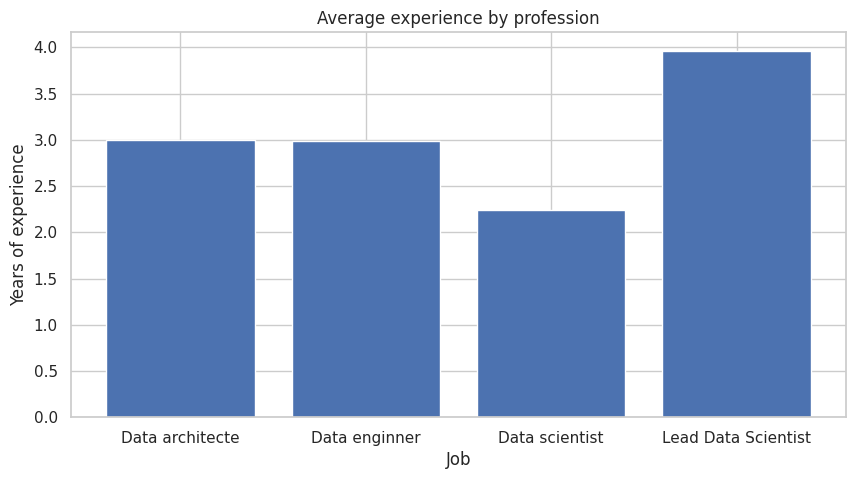

In [ ]:
#Histogram

X = ['Data architecte', 'Data enginner',  'Data scientist', 'Lead Data Scientist']
Y = [mean_data_architecte, mean_data_engineer, mean_data_scientist, mean_lead_data_scientist]

fig, ax = plt.subplots(figsize=(10,5))

plt.bar(X,Y)
plt.xlabel('Job')
plt.ylabel("Years of experience")
plt.title('Average experience by profession')

plt.show()

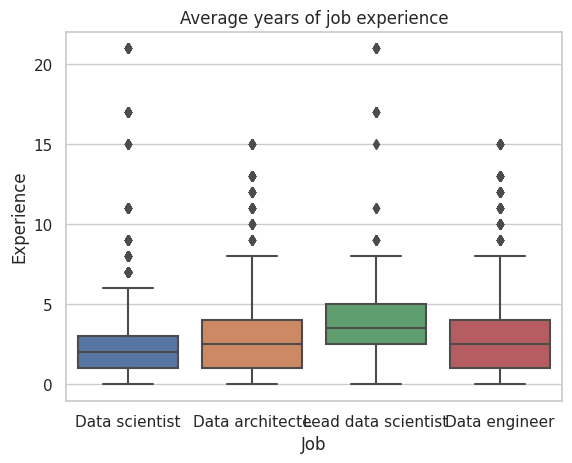

In [ ]:
# Boxplot

sns.boxplot(x='Metier', y='Experience', data = data)

plt.title("Average years of job experience")
plt.xlabel('Job')
plt.ylabel('Experience')

plt.show()

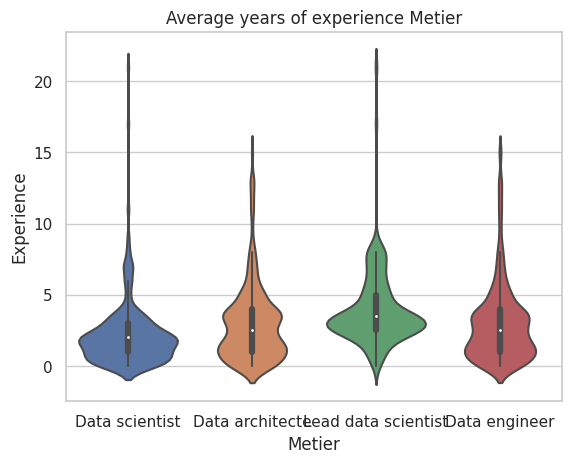

In [ ]:
#violinplot

sns.violinplot(x='Metier', y='Experience', data=data)

plt.title("Average years of experience Metier")
plt.xlabel('Metier')
plt.ylabel('Experience')

plt.show()

Transform the continuous variable 'Experience' into a new categorical variable 'Exp_label' with 4 categories: beginner, confirmed, advanced and expert.

In [ ]:
decile_40 = data['Experience'].quantile(0.40)
decile_70 = data['Experience'].quantile(0.70)
decile_90 = data['Experience'].quantile(0.90)

data['Exp_label'] = pd.cut(data['Experience'],
                           bins = [float('-inf'), decile_40, decile_70, decile_90, float('inf')],
                           labels = ['débutant', 'confirmé', 'avancé', 'expert'],
                           right = True)

data

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,débutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,confirmé
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,confirmé
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,débutant
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,confirmé
...,...,...,...,...,...,...,...
9577,Massachusetts General Hospital(MGH),Data scientist,C++/R/Python/Matlab/Matplotlib,Master,1.5,Lyon,débutant
9578,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,Master,11.0,Toulouse,expert
9579,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1.0,Paris,débutant
9580,Takeda Pharmaceutical,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17.0,Rennes,expert


In [ ]:
data.groupby(["Exp_label"])["Experience"].count()

Exp_label
débutant    3834
confirmé    3532
avancé      1369
expert       805
Name: Experience, dtype: int64

In [ ]:
data.groupby(["Metier", "Exp_label"])["Experience"].count()

Metier               Exp_label
Data architecte      débutant      854
                     confirmé      626
                     avancé        432
                     expert        188
Data engineer        débutant      946
                     confirmé      747
                     avancé        445
                     expert        209
Data scientist       débutant     1904
                     confirmé     1489
                     avancé        238
                     expert        234
Lead data scientist  débutant      122
                     confirmé      664
                     avancé        252
                     expert        171
Name: Experience, dtype: int64

Identification of the most commonly used technologies

In [ ]:
tech = data['Technologies'].str.split('/',expand=True)
tech

,0,1,2,3,4,5,6
0,Matlab,Python,Pyspark,Scikit-learn,Tensorflow,None,None
1,Python,Java,Scala,MongoDB,None,None,None
2,SPSS,SQL,Teradata,R,Python,Tensorflow,scikit-learn
3,C,C++,Java,Python,None,None,None
4,Matlab,Python,C++,numpy,Tensorflow,scikit-learn,None
...,...,...,...,...,...,...,...
9577,C++,R,Python,Matlab,Matplotlib,None,None
9578,Excel,Python,Matlab,R,machine learning,anglais,None
9579,R,machine learning,Excel,VBA,None,None,None
9580,Python,Pyspark,machine learning,Microsoft Azure,None,None,None


<Axes: title={'center': 'Technologies les plus utilisées'}, xlabel='Technologies', ylabel='Fréquence'>

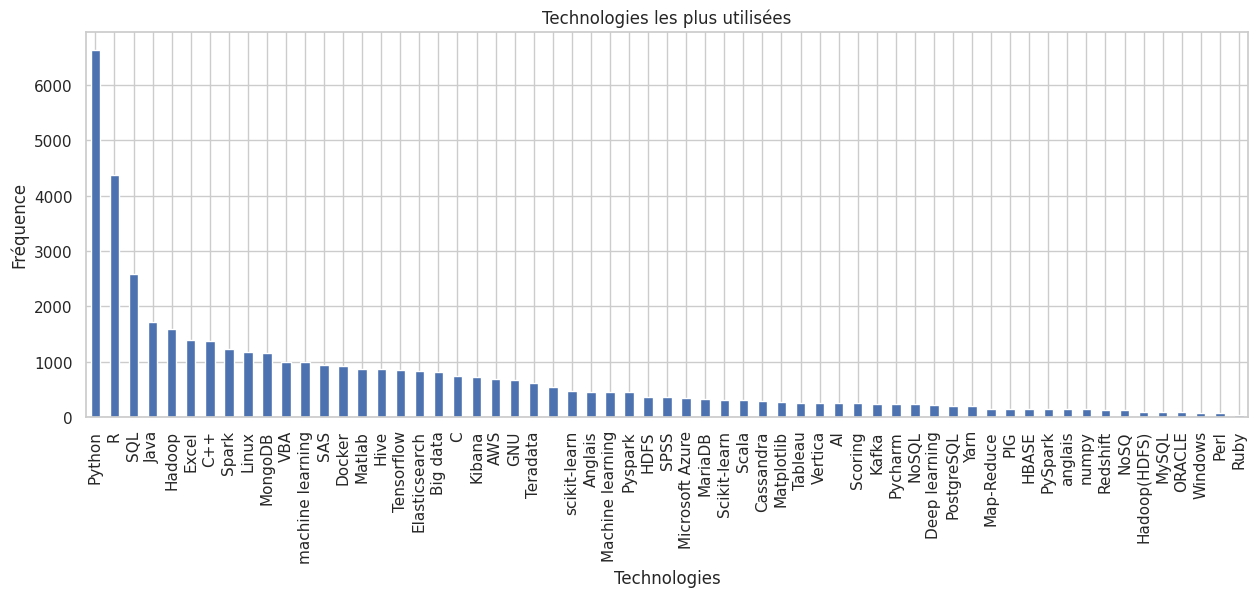

In [ ]:
tech_data = tech.stack().reset_index(drop=True)
technologies = tech_data.value_counts()

x = technologies
fig, ax = plt.subplots(figsize=(15,5))
x.plot.bar(x, title = 'Technologies les plus utilisées', xlabel = 'Technologies', ylabel = 'Fréquence')

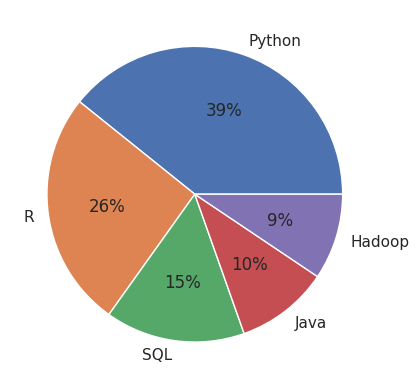

In [ ]:
top5 = list(technologies.keys())[:5]
top5value = list(technologies.values)[:5]

pieChart = plt.pie(top5value, labels=top5, autopct='%0.0f%%')
plt.show()

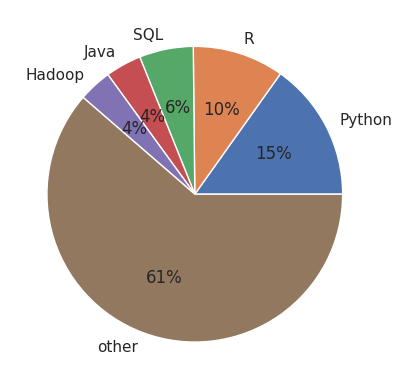

In [ ]:
top5.append('other')
top5value.append(sum(list(technologies.values)[5:]))

pieChart = plt.pie(top5value, labels=top5, autopct='%0.0f%%')
plt.show()

## Encoding


Encoding of Entreprise variable

In [ ]:
data['Entreprise'].value_counts()

Ball Aerospace                     748
KPMG                               132
Amazon.com                         127
Brigham & Women's Hospital(BWH)    115
Google                             112
                                  ... 
Aptus Health                         1
Wittaff Inc.                         1
BlueRock Therapeutics                1
Research Now                         1
Ra Pharmaceutical                    1
Name: Entreprise, Length: 1382, dtype: int64

In [ ]:
entreprise_counts = data['Entreprise'].value_counts()
total_entreprises = len(entreprise_counts)

# Sort companies in descending order of occurrence
sorted_entreprises = entreprise_counts.index[:total_entreprises]

# Calculation of deciles
decile_values = np.percentile(entreprise_counts, np.linspace(0, 100, 11))

# Create a dictionary to store the encoding values for each company
entreprise_encoded_dict = {}
for i in range(1, 11):
    lower_bound = decile_values[i - 1]
    upper_bound = decile_values[i]
    decile_group = sorted_entreprises[(entreprise_counts >= lower_bound) & (entreprise_counts <= upper_bound)]
    if i <= 2:
        decile_encoded_value = 'TPE'
    elif i <= 4:
        decile_encoded_value = 'PME'
    elif i <= 6:
        decile_encoded_value = 'ETI_1'
    elif i <= 8:
        decile_encoded_value = 'ETI_2'
    else:
        decile_encoded_value = 'GE'
    for entreprise in decile_group:
        entreprise_encoded_dict[entreprise] = decile_encoded_value

data['Entreprise_Encoded'] = data['Entreprise'].map(entreprise_encoded_dict)

data

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Entreprise_Encoded
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,débutant,GE
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,confirmé,GE
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,confirmé,GE
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,débutant,GE
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,confirmé,GE
...,...,...,...,...,...,...,...,...
9577,Massachusetts General Hospital(MGH),Data scientist,C++/R/Python/Matlab/Matplotlib,Master,1.5,Lyon,débutant,GE
9578,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,Master,11.0,Toulouse,expert,GE
9579,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1.0,Paris,débutant,GE
9580,Takeda Pharmaceutical,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17.0,Rennes,expert,GE


Encoding of city variable

In [ ]:
uploaded = files.upload()
agglo = pd.read_excel('agglo.xlsx')

agglo.head(5)

Saving agglo.xlsx to agglo (1).xlsx


,Commune,Population municipale 2017
0,Paris,12628266
1,Lyon,2323221
2,Marseille,1760653
3,Toulouse,1360829
4,Bordeaux,1247977


In [ ]:
# Merging two DataFrames 'data' and 'agglo' based on the 'City' column as an inner join
agglo.rename({'Commune': 'Ville', 'Population municipale 2017': 'Population 2017'}, axis=1, inplace=True)
df = data.merge(agglo, how='inner', on='Ville')
df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Entreprise_Encoded,Population 2017
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,débutant,GE,12628266
1,Fibroblast,Data architecte,Java/Linux/Docker,Bachelor,8.0,Paris,expert,ETI_1,12628266
2,Massachusetts General Hospital(MGH),Data scientist,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,2.0,Paris,confirmé,GE,12628266
3,Tempus,Data engineer,Linux/Python/Hadoop/Perl/Ruby,Master,0.0,Paris,débutant,GE,12628266
4,Harnham,Data scientist,SQL/R/Python//Big data,Master,5.0,Paris,avancé,GE,12628266
...,...,...,...,...,...,...,...,...,...
9577,Soroco,Data scientist,R/Python/SQL/NoSQL/MongoDB,Master,3.0,Rennes,confirmé,ETI_2,733320
9578,Google,Data scientist,Python/Tensorflow/R/Big data,Master,2.0,Rennes,confirmé,GE,733320
9579,Brammer Bio,Data scientist,C++/R/Python/Matlab/Matplotlib,Master,3.0,Rennes,confirmé,ETI_2,733320
9580,Cambridge Trust Company,Lead data scientist,R/Python/Hadoop/Hive/SQL,Master,8.0,Rennes,expert,ETI_2,733320


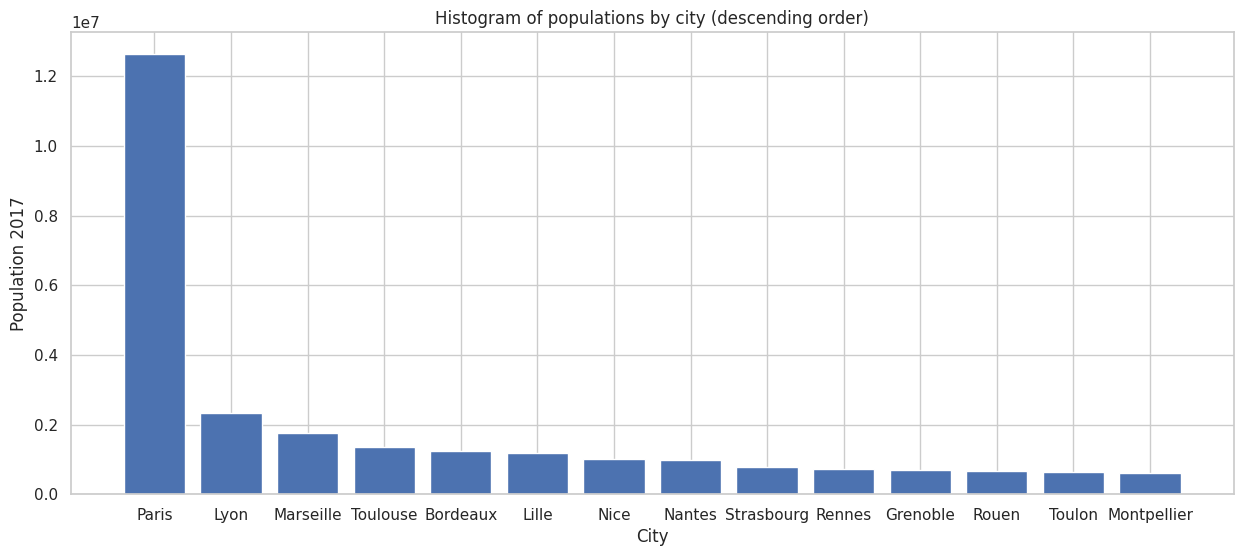

In [ ]:
df_sorted = df.sort_values(by='Population 2017', ascending=False)

x_values = df_sorted['Ville'].unique()
y_values = df_sorted['Population 2017'].unique()

plt.figure(figsize=(15, 6))
plt.bar(x_values, y_values)

plt.xlabel('City')
plt.ylabel('Population 2017')
plt.title('Histogram of populations by city (descending order)')

plt.show()

In [ ]:
# Defining bin boundaries and corresponding labels for population size categories
bins = [float('-inf'), 900000, 1500000, 10000000, float('inf')]
labels = ['small_city', 'average_city', 'big_city', 'paris']

# Using pd.cut() to categorize the values in the "Population 2017" column into the specified bins and assign labels
df['Ville_Encoded'] = pd.cut(df['Population 2017'], bins=bins, labels=labels, right=False)
df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Entreprise_Encoded,Population 2017,Ville_Encoded
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,débutant,GE,12628266,paris
1,Fibroblast,Data architecte,Java/Linux/Docker,Bachelor,8.0,Paris,expert,ETI_1,12628266,paris
2,Massachusetts General Hospital(MGH),Data scientist,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,2.0,Paris,confirmé,GE,12628266,paris
3,Tempus,Data engineer,Linux/Python/Hadoop/Perl/Ruby,Master,0.0,Paris,débutant,GE,12628266,paris
4,Harnham,Data scientist,SQL/R/Python//Big data,Master,5.0,Paris,avancé,GE,12628266,paris
...,...,...,...,...,...,...,...,...,...,...
9577,Soroco,Data scientist,R/Python/SQL/NoSQL/MongoDB,Master,3.0,Rennes,confirmé,ETI_2,733320,small_city
9578,Google,Data scientist,Python/Tensorflow/R/Big data,Master,2.0,Rennes,confirmé,GE,733320,small_city
9579,Brammer Bio,Data scientist,C++/R/Python/Matlab/Matplotlib,Master,3.0,Rennes,confirmé,ETI_2,733320,small_city
9580,Cambridge Trust Company,Lead data scientist,R/Python/Hadoop/Hive/SQL,Master,8.0,Rennes,expert,ETI_2,733320,small_city


Create dummies variables for each of the following variable : `technologies`, `Diplome`, `Exp_label`, `Entreprise_Encoded` and `Ville_Encoded`

In [ ]:
diplome = pd.get_dummies(df.Diplome)
exp = pd.get_dummies(df.Exp_label)
entreprise = pd.get_dummies(df.Entreprise_Encoded)
ville = pd.get_dummies(df.Ville_Encoded)

df_encoded = pd.concat([entreprise, ville, diplome, exp], axis=1)

for tech_i in technologies.index :
    tech_name = tech_i
    df_encoded[tech_name] = tech.isin([tech_i]).sum(axis = 1)

df_encoded['Metier'] = df['Metier']

df_encoded

,ETI_1,ETI_2,GE,PME,small_city,average_city,big_city,paris,Bachelor,Master,...,numpy,Redshift,NoSQ,Hadoop(HDFS),MySQL,ORACLE,Windows,Perl,Ruby,Metier
0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,Data scientist
1,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,Data architecte
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Data scientist
3,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,Data engineer
4,0,0,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,Data scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Data scientist
9578,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Data scientist
9579,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Data scientist
9580,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Lead data scientist


Split the dataset in two, with one part containing only non-labelled `df_NaN` data and a second part containing labelled data `df_encoded`.

In [ ]:
Nan = df_encoded[df_encoded['Metier'].isna()]
df_NaN = df_encoded[df_encoded['Metier'].isna()]
df_NaN

,ETI_1,ETI_2,GE,PME,small_city,average_city,big_city,paris,Bachelor,Master,...,numpy,Redshift,NoSQ,Hadoop(HDFS),MySQL,ORACLE,Windows,Perl,Ruby,Metier
77,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,NaN
1202,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,NaN
1392,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1919,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3172,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
3541,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
3551,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
4222,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
4447,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,NaN
5619,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN


In [ ]:
df_encoded = df_encoded.dropna()
df_encoded

,ETI_1,ETI_2,GE,PME,small_city,average_city,big_city,paris,Bachelor,Master,...,numpy,Redshift,NoSQ,Hadoop(HDFS),MySQL,ORACLE,Windows,Perl,Ruby,Metier
0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,Data scientist
1,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,Data architecte
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Data scientist
3,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,Data engineer
4,0,0,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,Data scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Data scientist
9578,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Data scientist
9579,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Data scientist
9580,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Lead data scientist


## Predict and replace the missing values

train and test set

In [ ]:

X = df_encoded.drop(['Metier'], axis = 1)
y = df_encoded['Metier']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 78)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7172, 77)
(2391, 77)
(7172,)
(2391,)


classification task using various machine learning algorithms, including k-Nearest Neighbors, Multi-layer Perceptron, Support Vector Machine, Gradient Boosting, Random Forest, and Naive Bayes and sorts the results by accuracy in descending order, providing a summary of the models' performance.

In [ ]:
def fit_and_get_performance(algo, X_train, y_train, X_test, y_test):
    model = algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

print("start")


seed_num = 10

knn_model = KNeighborsClassifier(n_jobs=-1)
mlp_model = MLPClassifier(random_state=seed_num, max_iter=20)
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
nb_model = GaussianNB()


column_names = ['Models', 'Accuracy']
Models_Scores = pd.DataFrame(columns=column_names)

Models = [knn_model, mlp_model, svm_model, gb_model, rf_model, nb_model]
Models_Column = ['k-Nearest Neighbors',
                 'multi layer perceptron',
                 'SVM',
                 'Gradient Boosting',
                 'Random Forest',
                 'Naive Bayes']

i = 0
for model in Models:
    print(str(model) + ' starting')
    accuracy = fit_and_get_performance(model, X_train, y_train, X_test, y_test)
    row = [Models_Column[i], accuracy]
    Models_Scores.loc[i + 1] = row
    i += 1

Models_Scores = Models_Scores.sort_values(by='Accuracy', ascending=False)
Models_Scores


start
KNeighborsClassifier(n_jobs=-1) starting
MLPClassifier(max_iter=20, random_state=10) starting


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


SVC(kernel='linear', random_state=42) starting
GradientBoostingClassifier(random_state=42) starting
RandomForestClassifier(random_state=42) starting
GaussianNB() starting


,Models,Accuracy
4,Gradient Boosting,0.465496
2,multi layer perceptron,0.457967
3,SVM,0.457967
5,Random Forest,0.395650
1,k-Nearest Neighbors,0.370556
6,Naive Bayes,0.259724


Select the top three models with the highest accuracy scores `Gradient Boosting`, `multi layer perceptron` and `SVM`. Perform a grid search on these selected models to optimize their performance further.

In [ ]:
# Models with their hyperparameter spaces to explore
models = [
    (MLPClassifier(max_iter=200), {'hidden_layer_sizes': [(50,), (100,), (50, 50)]}),
    (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200]})
]

# Collect results in a DataFrame
results = []
for model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_

    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    results.append({
        'Model': model.__class__.__name__,
        'Best Params': best_params,
        'Best CV Accuracy': best_accuracy,
        'Test Accuracy': test_accuracy
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

,Model,Best Params,Best CV Accuracy,Test Accuracy
0,MLPClassifier,"{'hidden_layer_sizes': (50,)}",0.426103,0.422417
1,SVC,"{'C': 1, 'kernel': 'linear'}",0.457056,0.457967
2,GradientBoostingClassifier,{'n_estimators': 50},0.455661,0.465496


I choose to look in more detail at the metrics of the two best algos on the accuracy test. Maybe XGBoost would have been a solution to explore in more detail since this algorithm is supposed to react better than LGBM on smaller datasets.

In [ ]:
svm_model = SVC(kernel='linear', C=1)
gb_model = GradientBoostingClassifier(n_estimators=50)

svm_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

print('----------------------------Gradient Boosting----------------------------')
print('')
print(classification_report(y_test, gb_model.predict(X_test)))
print('')
print('----------------------------SVM----------------------------')
print('')
print(classification_report(y_test, svm_model.predict(X_test)))

----------------------------Gradient Boosting----------------------------

                     precision    recall  f1-score   support

    Data architecte       0.38      0.20      0.26       513
      Data engineer       0.43      0.18      0.26       604
     Data scientist       0.49      0.91      0.63       958
Lead data scientist       0.28      0.06      0.10       316

           accuracy                           0.46      2391
          macro avg       0.39      0.34      0.31      2391
       weighted avg       0.42      0.46      0.39      2391


----------------------------SVM----------------------------

                     precision    recall  f1-score   support

    Data architecte       0.39      0.07      0.12       513
      Data engineer       0.39      0.29      0.33       604
     Data scientist       0.48      0.92      0.63       958
Lead data scientist       0.67      0.01      0.02       316

           accuracy                           0.46      2391
    

Based on the previous result, we will examine the results of the Gradient Boosting model

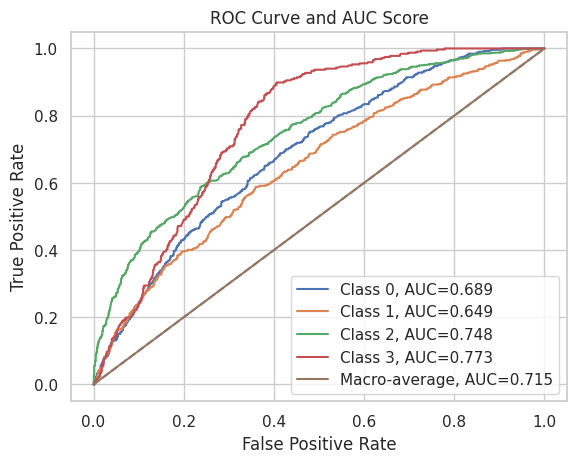

In [ ]:
y_pred_prob = gb_model.predict_proba(X_test)
classes = gb_model.classes_

# Calculate ROC curves and AUC scores for each class
aucs = []
for i, class_name in enumerate(classes):
    true_labels = y_test == class_name
    fpr, tpr, _ = roc_curve(true_labels, y_pred_prob[:, i])
    auc = roc_auc_score(true_labels, y_pred_prob[:, i])
    aucs.append(auc)
    plt.plot(fpr, tpr, label=f'Class {i}, AUC={auc:.3f}')

# Calculate the average macro AUC score
macro_auc = np.mean(aucs)

# Draw the diagonal line and the average AUC macro score
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot([0, 1], [0, 1], label=f'Macro-average, AUC={macro_auc:.3f}')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and AUC Score')
plt.show()

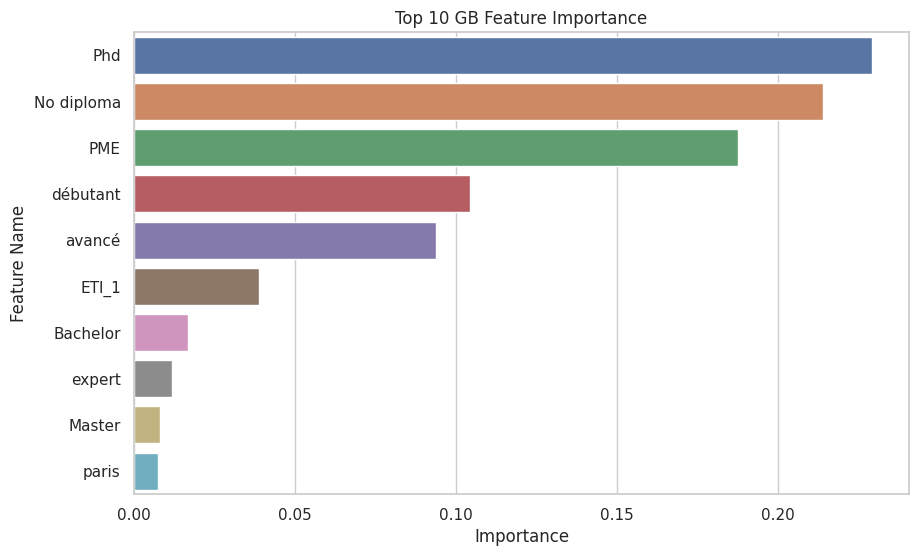

In [ ]:
featimp = pd.DataFrame({'name': X_train.columns,
                        'imp': gb_model.feature_importances_}).sort_values('imp', ascending=False)

top_featimp = featimp.head(10)
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x="imp", y="name", data=top_featimp, orient="h")

plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 GB Feature Importance')

plt.show()

Replace the missing job by the prediction of the Gradient Boosting model

In [ ]:
#drop Metier
df_NaN = df_NaN.drop(['Metier'],axis=1)

# Use the 'gb_model' to make predictions on the 'df_NaN' DataFrame
preds = gb_model.predict(df_NaN)

# Create a new DataFrame 'res' which contains the original rows with missing 'Metier' values along with their corresponding predictions.
res = df[df['Metier'].isna()]
res['pred_Metier'] = preds
res['pred_Metier'] = res['pred_Metier']
res

<ipython-input-94-e237aa81dd18>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['pred_Metier'] = preds
<ipython-input-94-e237aa81dd18>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['pred_Metier'] = res['pred_Metier']


,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Entreprise_Encoded,Population 2017,Ville_Encoded,pred_Metier
77,Jacobs,NaN,Python/Spark/GNU/Linux,No diploma,2.5,Paris,confirmé,GE,12628266,paris,Data engineer
1202,Ball Aerospace,NaN,Hadoop/Hive/Vertica/Tableau,Bachelor,3.0,Paris,confirmé,GE,12628266,paris,Data scientist
1392,Ball Aerospace,NaN,Hadoop/Hive/Vertica/Tableau,No diploma,0.0,Paris,débutant,GE,12628266,paris,Data architecte
1919,Klein Hersh International,NaN,Hadoop/Hive/Vertica/Tableau,No diploma,3.5,Paris,confirmé,GE,12628266,paris,Data architecte
3172,KPMG,NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,0.0,Marseille,débutant,GE,1760653,big_city,Data scientist
3541,McKinsey & Company,NaN,Python/R/machine learning/Excel/VBA/C++,Master,1.0,Marseille,débutant,GE,1760653,big_city,Data scientist
3551,Pearson,NaN,R/Python/Spark/Pycharm/SAS/SQL,Master,4.0,Marseille,avancé,GE,1760653,big_city,Data architecte
4222,Partners HealthCare(PHS),NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,8.0,Bordeaux,expert,GE,1247977,average_city,Lead data scientist
4447,Environmental Defense Fund,NaN,Map-Reduce/HDFS/PIG/HBASE/Python/Cassandra,Master,2.5,Bordeaux,confirmé,ETI_2,1247977,average_city,Data scientist
5619,"eHire, LLC",NaN,Java/C/C++/R/Python,Master,1.5,Toulouse,débutant,ETI_2,1360829,average_city,Data scientist
